In [57]:
import os
import sys
import os.path as op
from torch.nn import functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

from nltk import word_tokenize
from torch.nn.utils.rnn import pad_sequence
import gdown
from glob import glob
from sklearn.model_selection import train_test_split


# Load Datasets

## Load IMDB Dataset

In [2]:
# For those on google colab: you can download the files directly with this:
gdown.download("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", output="aclImdb_v1.tar.gz", quiet=False)
!tar xzf /content/aclImdb_v1.tar.gz

Downloading...
From: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
To: /content/aclImdb_v1.tar.gz
100%|██████████| 84.1M/84.1M [00:09<00:00, 8.80MB/s]


In [1]:
def get_imdb_dataset():
    # We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
    imdb_train_filenames_neg = sorted(
        glob(op.join(".", "aclImdb", "train", "neg", "*.txt"))
    )
    imdb_train_filenames_pos = sorted(
        glob(op.join(".", "aclImdb", "train", "pos", "*.txt"))
    )

    imdb_test_filenames_neg = sorted(
        glob(op.join(".", "aclImdb", "test", "neg", "*.txt"))
    )
    imdb_test_filenames_pos = sorted(
        glob(op.join(".", "aclImdb", "test", "pos", "*.txt"))
    )

    # Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
    imdb_train_texts_neg = [
        open(f, encoding="utf8").read() for f in imdb_train_filenames_neg
    ]
    imdb_train_texts_pos = [
        open(f, encoding="utf8").read() for f in imdb_train_filenames_pos
    ]
    imdb_train_texts = imdb_train_texts_neg + imdb_train_texts_pos

    imdb_test_texts_neg = [
        open(f, encoding="utf8").read() for f in imdb_test_filenames_neg
    ]
    imdb_test_texts_pos = [
        open(f, encoding="utf8").read() for f in imdb_test_filenames_pos
    ]
    imdb_test_texts = imdb_test_texts_neg + imdb_test_texts_pos

    # The first half of the elements of the list are string of negative reviews, and the second half positive ones
    # We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
    imdb_train_labels = np.ones(len(imdb_train_texts), dtype=int)
    imdb_train_labels[: len(imdb_train_texts_neg)] = 0.0

    imdb_test_labels = np.ones(len(imdb_test_texts), dtype=int)
    imdb_test_labels[: len(imdb_test_texts_neg)] = 0.0

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        imdb_train_texts, imdb_train_labels, test_size=0.2
    )

    return train_texts, test_texts, train_labels, test_labels

In [32]:
imdb_train_texts, imdb_test_texts, imdb_train_labels, imdb_test_labels = get_imdb_dataset()

## Load Movie Review Dataset

In [4]:
!pip install kaggle
!mkdir ~/.kaggle/ 
!cp kaggle.json ~/.kaggle/ # The kaggle.json is a file download from kaggle with your API codes (each has one to login)
!chmod 600 ~/.kaggle/kaggle.json 
!kaggle datasets download -d nltkdata/movie-review
!unzip /content/movie-review.zip -d /content/

In [34]:
def get_movie_review_dataset():
    movie_review_filenames_neg = sorted(
        glob(op.join(".", "movie_reviews", "movie_reviews", "neg", "*.txt"))
    )
    movie_review_filenames_pos = sorted(
        glob(op.join(".", "movie_reviews", "movie_reviews", "pos", "*.txt"))
    )

    # Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
    movie_review_texts_neg = [
        open(f, encoding="ascii").read() for f in movie_review_filenames_neg
    ]
    movie_review_texts_pos = [
        open(f, encoding="utf8").read() for f in movie_review_filenames_pos
    ]
    movie_review_texts = movie_review_texts_neg + movie_review_texts_pos
    movie_review_texts = list(map(lambda x: x.replace("\n", ""), movie_review_texts))

    # The first half of the elements of the list are string of negative reviews, and the second half positive ones
    # We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
    movie_review_labels = np.ones(len(movie_review_texts), dtype=int)
    movie_review_labels[: len(movie_review_texts_neg)] = 0.0

    train_texts, test_texts, train_labels, test_labels = train_test_split(
        movie_review_texts, movie_review_labels, test_size=0.2
    )

    return train_texts, test_texts, train_labels, test_labels

In [35]:
movie_review_train_texts, movie_review_test_texts, movie_review_train_labels, movie_review_test_labels = get_movie_review_dataset()

# Prelogits extraction

## Tokenize data

In [36]:
!pip install transformers

In [37]:
import transformers
import keras
from transformers import BertTokenizer, BertModel
import torch

In [38]:
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [39]:
def tokenize_texts(tokenizer, texts, length_texts=None):
    if not length_texts:
        length_texts = len(texts)
    else:
        length_texts = min(len(texts), length_texts)
    # Tokenize the input sentences
    encoded = tokenizer.batch_encode_plus(
        texts[:length_texts],
        add_special_tokens=True,
        # max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    # Get the input IDs, attention masks, and token type IDs
    input_ids = encoded["input_ids"].to(device)
    attention_masks = encoded["attention_mask"].to(device)
    token_type_ids = encoded["token_type_ids"].to(device)

    return input_ids, attention_masks, token_type_ids

In [40]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [41]:
# Get tokens for imdb dataset
imdb_input_ids_train, imdb_attention_masks_train, imdb_token_type_ids_train = tokenize_texts(tokenizer, imdb_train_texts, length_texts=200)
imdb_input_ids_test, imdb_attention_masks_test, imdb_token_type_ids_test = tokenize_texts(tokenizer, imdb_test_texts, length_texts=50)

# Get tokens for movie review dataset
movie_review_input_ids_train, movie_review_attention_masks_train, movie_review_token_type_ids_train = tokenize_texts(tokenizer, movie_review_train_texts, length_texts=20)
movie_review_input_ids_test, movie_review_attention_masks_test, movie_review_token_type_ids_test = tokenize_texts(tokenizer, movie_review_test_texts, length_texts=50)

In [42]:
print(imdb_input_ids_train.shape, imdb_input_ids_test.shape)
print(movie_review_input_ids_train.shape, movie_review_input_ids_test.shape)

torch.Size([200, 512]) torch.Size([50, 512])
torch.Size([20, 512]) torch.Size([50, 512])


## Get Prelogits

In [43]:
model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
#model

In [45]:
def get_prelogits(model, input_ids, attention_masks, token_type_ids):
    # Get the prelogits of the train dataset
    with torch.no_grad():
        outputs = model(input_ids, attention_masks, token_type_ids)
        prelogits = outputs[1].cpu().numpy()
    
    return prelogits

In [46]:
# Get prelogits for imdb
imdb_prelogits_train = get_prelogits(model, imdb_input_ids_train, imdb_attention_masks_train, imdb_token_type_ids_train)
imdb_prelogits_test = get_prelogits(model, imdb_input_ids_test, imdb_attention_masks_test, imdb_token_type_ids_test)

In [47]:
# Get prelogits for movie review
movie_review_prelogits_train = get_prelogits(model, movie_review_input_ids_train, movie_review_attention_masks_train, movie_review_token_type_ids_train)
movie_review_prelogits_test = get_prelogits(model, movie_review_input_ids_test, movie_review_attention_masks_test, movie_review_token_type_ids_test)

# Computing OOD

In [48]:
def np_softmax(zs):
  exps = np.exp(zs-np.max(zs))
  return exps/np.sum(exps,axis=-1,keepdims=True)

## Standard Mahalanobis

In [49]:
from sklearn.metrics import roc_auc_score

def maha_distance(xs,cov_inv_in,mean_in,norm_type=None):
  diffs = xs - mean_in.reshape([1,-1])

  second_powers = np.matmul(diffs,cov_inv_in)*diffs

  if norm_type in [None,"L2"]:
    return np.sum(second_powers,axis=1)
  elif norm_type in ["L1"]:
    return np.sum(np.sqrt(np.abs(second_powers)),axis=1)
  elif norm_type in ["Linfty"]:
    return np.max(second_powers,axis=1)

def get_scores(
    indist_train_embeds_in,
    indist_train_labels_in,
    indist_test_embeds_in,
    outdist_test_embeds_in,
    subtract_mean = True,
    normalize_to_unity = True,
    subtract_train_distance = True,
    indist_classes = 100,
    norm_name = "L2",
    ):
  
  # storing the replication results
  maha_intermediate_dict = dict()
  
  description = ""
  
  all_train_mean = np.mean(indist_train_embeds_in,axis=0,keepdims=True)

  indist_train_embeds_in_touse = indist_train_embeds_in
  indist_test_embeds_in_touse = indist_test_embeds_in
  outdist_test_embeds_in_touse = outdist_test_embeds_in

  if subtract_mean:
    indist_train_embeds_in_touse -= all_train_mean
    indist_test_embeds_in_touse -= all_train_mean
    outdist_test_embeds_in_touse -= all_train_mean
    description = description+" subtract mean,"

  if normalize_to_unity:
    indist_train_embeds_in_touse = indist_train_embeds_in_touse / np.linalg.norm(indist_train_embeds_in_touse,axis=1,keepdims=True)
    indist_test_embeds_in_touse = indist_test_embeds_in_touse / np.linalg.norm(indist_test_embeds_in_touse,axis=1,keepdims=True)
    outdist_test_embeds_in_touse = outdist_test_embeds_in_touse / np.linalg.norm(outdist_test_embeds_in_touse,axis=1,keepdims=True)
    description = description+" unit norm,"

  #full train single fit
  mean = np.mean(indist_train_embeds_in_touse,axis=0)
  cov = np.cov((indist_train_embeds_in_touse-(mean.reshape([1,-1]))).T)

  eps = 1e-8
  cov_inv = np.linalg.inv(cov)

  #getting per class means and covariances
  class_means = []
  class_cov_invs = []
  class_covs = []
  for c in range(indist_classes):

    mean_now = np.mean(indist_train_embeds_in_touse[indist_train_labels_in == c],axis=0)

    cov_now = np.cov((indist_train_embeds_in_touse[indist_train_labels_in == c]-(mean_now.reshape([1,-1]))).T)
    class_covs.append(cov_now)
    # print(c)

    eps = 1e-8
    cov_inv_now = np.linalg.inv(cov_now)

    class_cov_invs.append(cov_inv_now)
    class_means.append(mean_now)

  #the average covariance for class specific
  class_cov_invs = [np.linalg.inv(np.mean(np.stack(class_covs,axis=0),axis=0))]*len(class_covs)

  maha_intermediate_dict["class_cov_invs"] = class_cov_invs
  maha_intermediate_dict["class_means"] = class_means
  maha_intermediate_dict["cov_inv"] = cov_inv
  maha_intermediate_dict["mean"] = mean

  out_totrain = maha_distance(outdist_test_embeds_in_touse,cov_inv,mean,norm_name)
  in_totrain = maha_distance(indist_test_embeds_in_touse,cov_inv,mean,norm_name)

  out_totrainclasses = [maha_distance(outdist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]
  in_totrainclasses = [maha_distance(indist_test_embeds_in_touse,class_cov_invs[c],class_means[c],norm_name) for c in range(indist_classes)]

  out_scores = np.min(np.stack(out_totrainclasses,axis=0),axis=0)
  in_scores = np.min(np.stack(in_totrainclasses,axis=0),axis=0)

  if subtract_train_distance:
    out_scores = out_scores - out_totrain
    in_scores = in_scores - in_totrain


  onehots = np.array([1]*len(out_scores) + [0]*len(in_scores))
  scores = np.concatenate([out_scores,in_scores],axis=0)

  return onehots, scores, description, maha_intermediate_dict


In [50]:
from sklearn.metrics import roc_auc_score

def get_auroc(onehots,scores,make_plot = True,add_to_title=None,swap_classes=False):

  auroc = roc_auc_score(onehots, scores)

  to_replot_dict = dict()

  if swap_classes == False:
    out_scores,in_scores = scores[onehots==0], scores[onehots==1] 
  else:
    out_scores,in_scores = scores[onehots==1], scores[onehots==0] 

  if make_plot:
    plt.figure(figsize = (5.5,3),dpi=100)

    if add_to_title is not None:
      plt.title(add_to_title+" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)
    else:
      plt.title(" AUROC="+str(float(auroc*100))[:6]+"%",fontsize=14)


  vals,bins = np.histogram(out_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="navy",marker="",label="in test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="navy",alpha=0.3)

  to_replot_dict["out_bin_centers"] = bin_centers
  to_replot_dict["out_vals"] = vals

  vals,bins = np.histogram(in_scores,bins = 51)
  bin_centers = (bins[1:]+bins[:-1])/2.0

  if make_plot:
    plt.plot(bin_centers,vals,linewidth=4,color="crimson",marker="",label="out test")
    plt.fill_between(bin_centers,vals,[0]*len(vals),color="crimson",alpha=0.3)

  to_replot_dict["in_bin_centers"] = bin_centers
  to_replot_dict["in_vals"] = vals

  if make_plot:
    plt.xlabel("Score",fontsize=14)
    plt.ylabel("Count",fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    plt.ylim([0,None])

    plt.legend(fontsize = 14)

    plt.tight_layout()
    plt.show()

  return auroc,to_replot_dict

In [51]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(imdb_prelogits_train)[:,:],
        imdb_train_labels[:200],
        np.array(imdb_prelogits_test)[:,:],
        np.array(movie_review_prelogits_test)[:,:],
        indist_classes=2,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )

In [53]:
class_means = maha_intermediate_dict["class_means"]
class_cov_invs = maha_intermediate_dict["class_cov_invs"]

indist_test_embeds = imdb_prelogits_test

outdist_test_embeds = movie_review_prelogits_test

indist_dists = []
for c in range(2):
  indist_offset_now = indist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(indist_offset_now,class_cov_invs[c])*indist_offset_now,axis=1)
  indist_dists.append(maha_dists_now)

outdist_dists = []
for c in range(2):
  outdist_offset_now = outdist_test_embeds - class_means[c].reshape([1,-1])
  maha_dists_now = np.sum(np.matmul(outdist_offset_now,class_cov_invs[c])*outdist_offset_now,axis=1)
  outdist_dists.append(maha_dists_now)

In [54]:

indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [55]:
print("IMDB score = "+str(np.mean(indist_min))+"+-"+str(np.std(indist_min)))
print("Movie Review score = "+str(np.mean(outdist_min))+"+-"+str(np.std(outdist_min)))

IMDB score = -764413047750111.6+-3294808014476882.5
Movie Review score = 1.5106323727746302e+20+-1.0677890326808653e+21


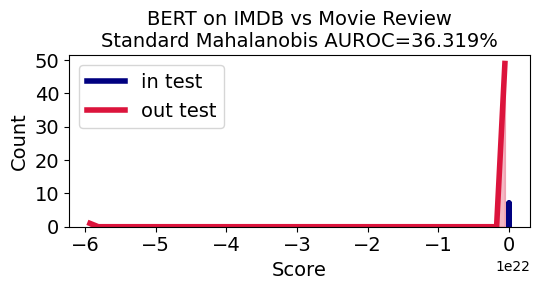

In [77]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="BERT on IMDB vs Movie Review\nStandard Mahalanobis"
    )

In [59]:
auroc

0.4048

### Relative Mahalanobis

In [61]:
train_mean = maha_intermediate_dict["mean"]
train_cov_inv = maha_intermediate_dict["cov_inv"]

In [69]:
onehots, scores, description, maha_intermediate_dict = get_scores(
        np.array(imdb_prelogits_train)[:,:],
        imdb_train_labels[:200],
        np.array(imdb_prelogits_test)[:,:],
        np.array(movie_review_prelogits_test)[:,:],
        indist_classes=2,
        subtract_mean = False,
        normalize_to_unity = False,
        subtract_train_distance = False,
    )

In [70]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_min,indist_min],axis=0)

In [73]:
indist_dists_byclass = np.stack(indist_dists,axis=1)
indist_min = np.min(indist_dists_byclass,axis=1)

outdist_dists_byclass = np.stack(outdist_dists,axis=1)
outdist_min = np.min(outdist_dists_byclass,axis=1)

prelogits = indist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
indist_train_dist = train_maha_dist

prelogits = outdist_test_embeds
offset_now = prelogits - np.array(train_mean).reshape([1,-1]).astype(np.float64)
offset_now = offset_now.astype(np.float64)
train_maha_dist = np.einsum("ai,ij->aj",offset_now,np.array(train_cov_inv).astype(np.float64))
train_maha_dist = np.einsum("aj,aj->a",train_maha_dist,offset_now)
outdist_train_dist = train_maha_dist

outdist_scores = outdist_min-outdist_train_dist
indist_scores = indist_min-indist_train_dist

onehots = np.array([1]*len(outdist_min) + [0]*len(indist_min))
scores = np.concatenate([outdist_scores,indist_scores],axis=0)

In [74]:
print("IMDB score = "+str(np.mean(indist_scores))+"+-"+str(np.std(indist_scores)))
print("Movie Review score = "+str(np.mean(outdist_scores))+"+-"+str(np.std(outdist_scores)))

IMDB score = 3324966634415419.0+-1.113575324784917e+16
Movie Review score = -1.1998553358851016e+21+-8.387621748035837e+21


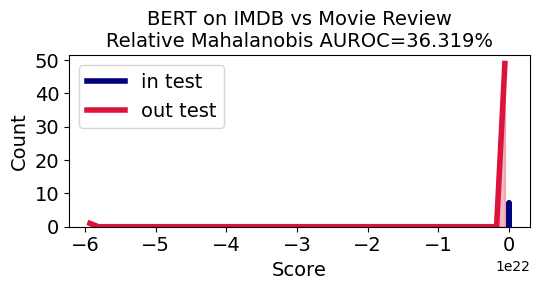

In [76]:
auroc, to_replot_dict = get_auroc(
    onehots, 
    scores, 
    make_plot=True,
    add_to_title="BERT on IMDB vs Movie Review\nRelative Mahalanobis"
    )
     